# Steps
1. train layer 1, obtain layer 1 model
2. generate layer 2 predictions, convert to 3 columns, set to 1s and 0s
3. train layer 2, obtain layer 2 model

## 1. Read HMM profiles

Import core modules

In [5]:
import pandas as pd
import numpy as np
import os
import sys

Read .hmm files

In [24]:
path = '/homes/adrozdetskiy/Projects/JnetDatasets/training_onFull_20140715/'

all_file_names = os.listdir(path)

hmm_file_names = [f for f in all_file_names if ('.hmm' in f)]
len(hmm_file_names)

# read in sequence dictionary containing internal ID and SCOPe IDs
# name this dictionary sd
sd = pd.read_csv('/homes/2472402/data/seq_dict.txt', names = ['jnetID', 'scopeID']).set_index('jnetID')

# have to do this naming of sub domains
sd[sd.index==int('23183')] = 'e1gk9.1A'
sd[sd.index==int('23184')] = 'e1gk9.1B'
sd[sd.index==int('23185')] = 'e1mtp.1A'
sd[sd.index==int('23187')] = 'e1n13.1A'
sd[sd.index==int('23188')] = 'e1n13.1B'
sd[sd.index==int('23189')] = 'e1qd6.1C'

In [16]:
hmm = [pd.read_csv(path+hmm, delimiter=' ', names=list(range(0,24))) for hmm in hmm_file_names[0:1]]
# hmm[0:1]
hmm_file_names[0]

'23155.hmm'

## 2. Convert profile hmm to 1D patterns

define function to get a bunch of linearized patterns from a single sequence i.e. do windowing and linearzing at the same time

given a df and flank size
calculate sequence length (df index dimension)
initialize a 2D array
for every row in hmm df:
    get window start index and window end index
    initialize a 1d array that is 17 x 24 = 408 cells long
    initialize a location based index to 0 for the array
    initialize an index for window position (i-8, i+8)
    for every window position index:
        if the window position is <0 or > length of the sequence, 
            assign the next 24 positions in the array to 0
            increment the location index by 24 (same number of times as the number of values assigned)
            continue
        else
            assert that all 24 values in that row are not NaN
            assign the next 24 positions in the array to the 24 values in that row
            continue
        increment window position index
     append 1d array to 2d array
check that 2d array has same number of rows as input df
return 2d array

In [33]:
# array: numpy array
# flank: positive integer

def sliding_window(array, flank):
    assert flank > 0
    assert type(array) is np.ndarray
    assert np.logical_not(np.isnan(np.sum(array)))
    nrow = array.shape[0]
    assert nrow > 0
    ncol = array.shape[1]
    assert ncol > 0
    res = np.empty(shape=(nrow, (2*flank+1)*ncol))
    res[:] = np.nan
    for i in list(range(0,nrow)):
        s, e = i-flank, i+flank+1
        k = 0;
        for j in list(range(s,e)):
            if (j < 0 or j >= nrow):
                res[i, k:k+ncol] = 0
            else:
                assert np.logical_not(np.isnan(np.sum(array[j])))
                assert array[j].shape == (ncol,)
                res[i, k:k+ncol] = array[j]
            k += ncol
    assert np.logical_not(np.isnan(np.sum(res)))
    assert res.shape == (nrow, (2*flank+1)*ncol)
    return res

In [19]:
def get_dssp(path):
    ls = list(pd.read_csv(path).loc[0].values)
    ls[0] = ls[0][-1:] # remove the DSSP: part from first list item
    res = np.empty(shape=(len(ls),3))
    res[:] = np.nan
    for i in range(0,len(ls)):
        if ls[i] == 'H':
            res[i] = np.array([1,0,0])
        else:
            if ls[i] == 'E' or ls[i] == 'B':
                res[i] = np.array([0,1,0])
            else:
                assert ls[i] != None
                res[i] = np.array([0,0,1])
    assert not np.isnan(np.sum(res))
    return res

In [35]:
dssp_dir = '/homes/adrozdetskiy/Projects/JnetDatasets/DSSP_out/'

results = []

for fn in hmm_file_names:
    hmm = pd.read_csv(path+fn, delimiter=' ', names=list(range(0,24)))
    pats = sliding_window(np.array(hmm), 8)
    seqID = sd[sd.index==int(fn[:-4])].scopeID.values[0]
    dssp_path = dssp_dir + seqID + '.sec'
    dssp = get_dssp(dssp_path)
    res = np.concatenate((pats,dssp), axis=1)
    assert not np.isnan(np.sum(res))
    assert res.shape == (pats.shape[0], pats.shape[1]+3)
    results.append(res)

In [36]:
import pickle

pickle.dump(results, open('/cluster/gjb_lab/2472402/data/hmm-data/hmmpat.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)

# Prepare data for cross-validation

In [4]:
import pickle
results = pickle.load(open('/cluster/gjb_lab/2472402/data/hmm-data/hmmpat.pkl','rb'))

In [8]:
results[0]

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [3.8790e-02, 2.2800e-03, 1.6000e-04, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.5059e-01, 2.3685e-01, 1.9000e-04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.9140e-02, 3.2700e-03, 9.0378e-01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [52]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


X = np.concatenate([r[:, :-3] for r in results], axis=0)
y = np.concatenate([r[:, -3:] for r in results], axis=0)

print('X.shape: ' ,X.shape, '\n', 'y.shape: ', y.shape, '\n')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=6000, test_size=1000, random_state=0)

# define a simple model for sequence to structure prediction
model = keras.Sequential([
    layers.Dense(units=100, activation='sigmoid', input_shape=[408]), 
    layers.Dense(units=3, activation='softmax')
])

# compile mode. note metrics argument is left out
model.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128, # not optimised
    epochs=250, # same as jnet v2.3.1
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)

model.save('/homes/2472402/data/hmm1.model')

X.shape:  (214436, 408) 
 y.shape:  (214436, 3) 

INFO:tensorflow:Assets written to: /homes/2472402/data/hmm1.model/assets


Minimum validation loss: 0.6250818967819214


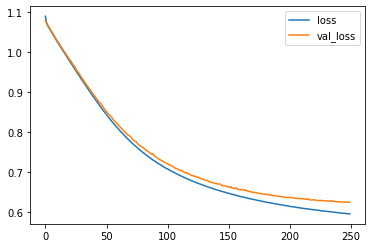

In [53]:
# review results
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))